In [1]:
import sys, pathlib, time, os
sys.path.append("../models/")
sys.path.append("../scripts/")

print("importing Patches")
# from peaks_pygdata import Patches
from peaks_dirac import DiracPatches

print("importing dependencies")
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tqdm, gc, datetime
import matplotlib.pyplot as plt
import joblib 

print("importing torch")
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as utils_DataLoader
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

importing Patches
nthreads = 256
ncores = 128
nthreads_per_core = 2
nthreads_available = 256
ncores_available = 128
MPI VERSION    : CRAY MPICH version 8.1.25.17 (ANL base 3.4a2)
MPI BUILD INFO : Sun Feb 26 15:15 2023 (git hash aecd99f)

I'm on perlmutter!
importing dependencies
importing torch
cuda:0


In [2]:
out_name = "20240220_EdgeNN_permute"

print("loading dataset")
dataset_name = "20231216dirac"
dataset = DiracPatches(dataset_name, [21.0, 86.], [0, 1, 2, 3])
# orig_labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
orig_labels = ['om', 'h', 's8', 'w', 'ob', 'ns']
indices = orig_labels.index("om"), orig_labels.index("s8")
num_classes = len(indices)

batch_size = 128
# note that this slicing does not bring the dataset into memory
train_dataset, val_dataset, test_dataset = dataset[:int(0.8 * len(dataset))], \
    dataset[int(0.8 * len(dataset)):int(0.9 * len(dataset))], dataset[int(0.9 * len(dataset)):]
# train_dataset, val_dataset, test_dataset = dataset[:batch_size*10], \
#     dataset[batch_size*10:batch_size*11], dataset[batch_size*11:batch_size*12] # debugging

print(batch_size, len(train_dataset) / batch_size, \
      len(train_dataset), len(val_dataset), len(test_dataset), len(dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

loading dataset
Preprocessing healpy
Preprocessed healpy loaded in 8.009647607803345 seconds
128 306.390625 39218 4902 4903 49023


In [3]:
print("scaling")
try:
    scaler = joblib.load(f"../outs/{out_name}/scaler.pkl")
except:
    scaler = MinMaxScaler()
    true = np.array([])
    for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        for j, dpt in enumerate(data):
            if j == 0 and True:
                true = np.append(true, dpt.y)
                # chk = dpt.y
                # chk_ng = dpt.num_graphs
            # else:
            #     assert np.allclose(chk, dpt.y)
            #     assert chk_ng == dpt.num_graphs
    scaler.fit(true.reshape(-1, 6)[:, indices])
    joblib.dump(scaler, f"../outs/{out_name}/scaler.pkl")

scaling


In [4]:
import torch, torchist
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool, BatchNorm
from torch.nn import Linear, BatchNorm1d, ReLU, Parameter, Module
from torch_geometric.nn import aggr, MessagePassing
from torch_geometric.utils import unbatch, add_self_loops
import tqdm, gc, numpy as np
from BaseGNN import baseGNN, base_set_up_model, train, test, predict
from torch_geometric.nn.inits import ones

import matplotlib.pyplot as plt

class EdgeNNLayer(MessagePassing):
    def __init__(self, d0=45/60): # linking length in degrees
        super().__init__(aggr='mean') # get sum of contributions from neighbouring peaks
        self.d0 = d0
        self.beta = Parameter(torch.empty(1))
        self.reset_parameters()
        self.weight_aggr = aggr.SumAggregation()
    
    def reset_parameters(self):
        print("resetting parameters")
        # set to 1 / d0
        self.beta.data[0] = 1 / self.d0
        # ones(self.beta)
    
    def message(self, x_i, x_j, edge_attr):
        beta = self.beta.clone()
        return x_j * torch.exp(-beta * edge_attr[:, 0:1]), torch.exp(-beta * edge_attr[:, 0:1])
        # return x_i * self.beta, x_i * self.beta
    
    def forward(self, x, edge_index, edge_attr):
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=0, num_nodes=x.shape[0])
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)
        # add in the self contribution and then average over all nodes
        
    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        vals, weights = inputs
        return self.aggr_module(vals, index, ptr=ptr, dim_size=dim_size, dim=self.node_dim)# / self.weight_aggr(weights, index, ptr, dim_size)


In [73]:
try:
    histograms_edgex = np.load(f"../outs/{out_name}/histograms_edgex.npy")
    histograms_resx = np.load(f"../outs/{out_name}/histograms_resx.npy")
    # weird -1 index is corrupted
    if False:
        histograms_edgex = histograms_edgex[:-1]
        histograms_resx = histograms_resx[:-1]
except:
    print("making histograms")
    
    nbins, scales, tomobins = 14, [21.0, 86.], [0, 1, 2, 3]
    
    def get_sm_t_idx(smi, ti):
        return smi + ti * len(scales)
    
    def compute_bin_extrema(ex_file='/pscratch/sd/s/shubh/graph_data/dirac_peaks_extrema.npy'):
        ex = np.load(ex_file, allow_pickle=True).item()
        bins = np.empty((len(scales)*len(tomobins), nbins+1))
        for smi, sm in enumerate(scales):
            for ti, t in enumerate(tomobins):
                bins[get_sm_t_idx(smi, ti)] = np.linspace(ex[t][sm][0],ex[t][sm][1], nbins+1)
        return torch.tensor(bins).to(torch.float32)
    
    bins = compute_bin_extrema()
    
    histograms_edgex = np.empty((0, len(scales)*len(tomobins), nbins))
    histograms_resx = np.empty((0, len(scales)*len(tomobins), nbins))
    
    edge_layer = EdgeNNLayer()
    
    for i, data in tqdm.tqdm(enumerate(full_loader), total=len(full_loader)):
        edgex, resx = {}, {}
        num_graphs = data[0].num_graphs
        h1 = torch.empty((num_graphs, len(scales)*len(tomobins), nbins)).to(data[0].x.device)
        h2 = torch.empty((num_graphs, len(scales)*len(tomobins), nbins)).to(data[0].x.device)
        for sm in range(len(scales)):
            for t in range(len(tomobins)):
                smtidx = get_sm_t_idx(sm, t)
                dpt = data[smtidx]
                x, edge_index, edge_attr = dpt.x, dpt.edge_index.to(torch.int64), dpt.edge_attr
                resx[smtidx] = unbatch(x, dpt.batch)
                
                # add random permutation
                x = x[torch.randperm(x.shape[0])]
                
                out = edge_layer(x, edge_index, edge_attr)
                edgex[smtidx] = unbatch(out, dpt.batch)
                for bi, bpt in enumerate(resx[smtidx]):
                    h1[bi, smtidx, :] = torchist.histogram(bpt, edges=bins[smtidx])
                for bi, bpt in enumerate(edgex[smtidx]):
                    h2[bi, smtidx, :] = torchist.histogram(bpt, edges=bins[smtidx])
        histograms_resx = np.append(histograms_resx, h1.detach().numpy(), axis=0)
        histograms_edgex = np.append(histograms_edgex, h2.detach().numpy(), axis=0)
    np.save(f"../outs/{out_name}/histograms_edgex.npy", histograms_edgex)
    np.save(f"../outs/{out_name}/histograms_resx.npy", histograms_resx)

making histograms
resetting parameters


  0%|          | 0/383 [00:00<?, ?it/s]

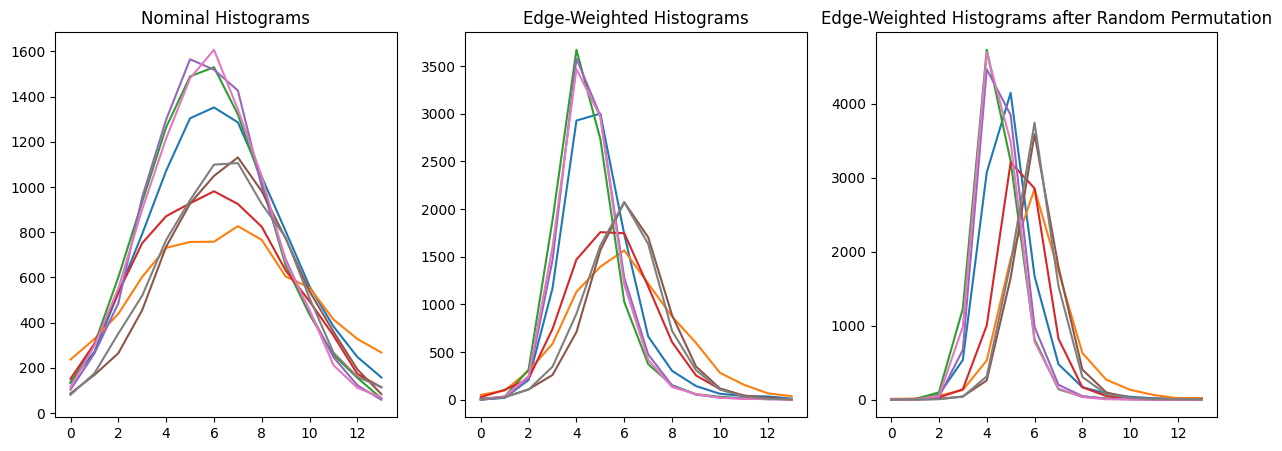

In [72]:
hresx = np.load(f"../outs/20240220_EdgeNN/histograms_resx.npy")
hedgex = np.load(f"../outs/20240220_EdgeNN/histograms_edgex.npy")
index = 8
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(hresx[index].T)
ax1.set_title("Nominal Histograms")
ax2.plot(hedgex[index].T)
ax2.set_title("Edge-Weighted Histograms")
ax3.plot(histograms_edgex[index].T)
ax3.set_title("Edge-Weighted Histograms after Random Permutation")
plt.show()
plt.close()

In [49]:
print(histograms_edgex.shape, histograms_resx.shape)

(128, 8, 14) (128, 8, 14)


In [36]:
concat_hists = np.concatenate([histograms_edgex.reshape(histograms_edgex.shape[0], -1), \
    histograms_resx.reshape(histograms_resx.shape[0], -1)], axis=1)

# concat_hists = histograms_resx.reshape(histograms_resx.shape[0], -1)

print(concat_hists.shape)

hist_trainloader = utils_DataLoader(concat_hists[:int(0.8 * len(concat_hists))], batch_size=batch_size, shuffle=False)
hist_valloader = utils_DataLoader(concat_hists[int(0.8 * len(concat_hists)):int(0.9 * len(concat_hists))], batch_size=batch_size, shuffle=False)
hist_testloader = utils_DataLoader(concat_hists[int(0.9 * len(concat_hists)):], batch_size=batch_size, shuffle=False)

print(len(hist_trainloader), len(hist_valloader), len(hist_testloader))
print(len(train_loader), len(val_loader), len(test_loader))

(49023, 224)
307 39 39
307 39 39


In [37]:
len(hist_trainloader.dataset), len(hist_valloader.dataset), len(hist_testloader.dataset)

(39218, 4902, 4903)

In [38]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(39218, 4902, 4903)

In [39]:
import PrimitiveNN as pn
from importlib import reload
pn = reload(pn)

num_epochs = 25
best_epoch = -1
pathlib.Path(f"../outs/{out_name}/chkpts/").mkdir(parents=True, exist_ok=True)
overwrite_epochs = False
overwrite_logs = False

if overwrite_logs:
    if os.path.exists(f"../outs/{out_name}/log.txt"):
        os.remove(f"../outs/{out_name}/log.txt")
else:
    with open(f"../outs/{out_name}/log.txt", "a") as f:
        f.write("Starting new run\n at " + str(datetime.datetime.now()) + "\n")
        print("Starting new run\n at " + str(datetime.datetime.now()) + "\n")
        
model, optimizer, criterion = pn.set_up_model(dataset, num_classes, device)
args = model, optimizer, criterion, scaler, indices, device

best_val_loss = np.inf
best_epoch = 23
print("training")
for epoch in range(num_epochs):
    with open(f"../outs/{out_name}/log.txt", "a") as f:
        if not overwrite_epochs and os.path.exists(f"../outs/{out_name}/chkpts/{epoch}.pt"):
            model.load_state_dict(torch.load(f"../outs/{out_name}/chkpts/{epoch}.pt"))
            print(f"Loaded model from epoch {epoch}")
            f.write(f"Loaded model from epoch {epoch}\n")
            continue
        start = time.time()
        print(f"Epoch {epoch}")
        train_loss = pn.train(zip(hist_trainloader, train_loader), *args, len(train_loader.dataset))
        val_loss = pn.test(zip(hist_valloader, val_loader), *args, len(val_loader.dataset))

        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        f.write(f'Epoch: {epoch:03d}, Train Loss: {train_loss}, Val Loss: {val_loss}\n')
        print(f"Time: {time.time() - start:.4f}s")
        f.write(f"Time: {time.time() - start:.4f}s\n")

        torch.save(model.state_dict(), f"../outs/{out_name}/chkpts/{epoch}.pt")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), f"../outs/{out_name}/best_model.pt")
            f.write(f"New best model saved at epoch {epoch}\n")

        del train_loss, val_loss
        gc.collect()
        torch.cuda.empty_cache()
        
print("saving model")
torch.save(model.state_dict(), f"../outs/{out_name}/last_model.pt")

def plotting_for_mse_loss(hist_loader, loader, pred_true_filename, hist_filenames):
    print("predicting")
    preds, true = pn.predict(zip(hist_loader, loader), *args, len(loader.dataset))

    np.save(f"../outs/{out_name}/preds.npy", preds)
    np.save(f"../outs/{out_name}/true.npy", true)

    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    for i in range(2):
        axs[i].scatter(true[:, i], preds[:, i], s=1)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
        axs[i].set_title(orig_labels[indices[i]])
        axs[i].plot([np.min(true[:, i]), np.max(true[:, i])], \
                    [np.min(true[:, i]), np.max(true[:, i])], c="k")
        axs[i].grid()
    plt.tight_layout()
    plt.savefig(pred_true_filename)
    plt.close()

    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    for i in range(2):
        axs[i].hist(true[:, i] - preds[:, i], bins=100, histtype="step", density=True)
        axs[i].set_xlabel("True - Predicted")
        axs[i].set_ylabel("Count")
        axs[i].set_title(orig_labels[indices[i]])
        axs[i].grid()
    plt.tight_layout()
    plt.savefig(hist_filenames)
    plt.close()


plotting = plotting_for_mse_loss

if True or best_epoch != num_epochs - 1:
    print(f"Loading best model from epoch {best_epoch}")
    model.load_state_dict(torch.load(f"../outs/{out_name}/best_model.pt"))
    # plotting(hist_trainloader, train_loader, f"../outs/{out_name}/best_pred_true.png", f"../outs/{out_name}/best_hist.png")
    plotting(hist_valloader, val_loader, f"../outs/{out_name}/val_best_pred_true.png", f"../outs/{out_name}/val_best_hist.png")
    plotting(hist_testloader, test_loader, f"../outs/{out_name}/test_best_pred_true.png", f"../outs/{out_name}/test_best_hist.png")

Starting new run
 at 2024-02-27 17:27:10.324838

initializing model
training
Loaded model from epoch 0
Loaded model from epoch 1
Loaded model from epoch 2
Loaded model from epoch 3
Loaded model from epoch 4
Loaded model from epoch 5
Loaded model from epoch 6
Loaded model from epoch 7
Loaded model from epoch 8
Loaded model from epoch 9
Loaded model from epoch 10
Loaded model from epoch 11
Loaded model from epoch 12
Loaded model from epoch 13
Loaded model from epoch 14
Loaded model from epoch 15
Loaded model from epoch 16
Loaded model from epoch 17
Loaded model from epoch 18
Loaded model from epoch 19
Loaded model from epoch 20
Loaded model from epoch 21
Loaded model from epoch 22
Loaded model from epoch 23
Loaded model from epoch 24
saving model
Loading best model from epoch 23
predicting


39it [04:04,  6.27s/it]


predicting


39it [04:03,  6.25s/it]


In [29]:
preds = np.load(f"../outs/{out_name}/preds.npy")
true = np.load(f"../outs/{out_name}/true.npy")

print(preds.shape, true.shape)

(39219, 2) (39218, 2)
